In [2]:
#from modules.utils import sorter, cleaner
from modules.preprocess import loader, sample_print
#from modules. evaluation import train_plot
from keras import models, optimizers

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

#import splitfolders

from modules.utils import cleaner

import os, shutil

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [37]:
print(len(os.listdir("data/raw/others")))
print(len(os.listdir("data/raw/pistols")))
print(len(os.listdir("data/cooked/train")))
print(len(os.listdir("data/cooked/test")))
print(len(os.listdir("data/cooked/validation")))


7771
7771
3
3
3


# SORTER RATIO FIX

In [31]:
def sorter(train_size, test_size, valid_size):
    # iterate over the files in the folders, split depending on the pre-set tresholds 
    for cat in ["others","pistols"]:
        totalcount = len(os.listdir("data/raw/" + cat))
        for filecount, filename in enumerate(os.listdir("data/raw/"+cat)):
            # if the sum of desired is more than number of pics, this will break
            if filecount < train_size*totalcount:
                src = os.path.join("data/raw/"+cat,filename)
                dst = os.path.join("data/cooked/train/"+cat, filename)
                shutil.copyfile(src,dst)
            elif filecount < (train_size*totalcount + test_size*totalcount):
                src = os.path.join("data/raw/"+cat,filename)
                dst = os.path.join("data/cooked/test/"+cat, filename)
                shutil.copyfile(src,dst)
            else:
                src = os.path.join("data/raw/"+cat,filename)
                dst = os.path.join("data/cooked/validation/"+cat, filename)
                shutil.copyfile(src,dst)

In [36]:
# Use this before pushing to repo
[cleaner(i) for i in ["train","test","validation"]]

sorter(.6,.2,.2)

# LOADER - IMAGEGENERATOR FIX

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

def loader(split_type, augmentation, target_size = (150,150), batch_size=32,*argz, **kwargz):
    if augmentation == False:
        train_datagen = ImageDataGenerator(rescale=1./255)
        training_set = train_datagen.flow_from_directory(("data/cooked/"+split_type), target_size = target_size, batch_size = batch_size, class_mode = 'binary')

    else:
        train_datagen = ImageDataGenerator(rescale=1./255,*argz, **kwargz)
        training_set = train_datagen.flow_from_directory(("data/cooked/"+split_type), target_size = target_size, batch_size = batch_size, class_mode = 'binary')

    return training_set

In [39]:
train = loader("train", 
augmentation = True, 
batch_size = 100, 
rotation_range= 45, 
width_shift_range=.2, 
height_shift_range=.2, 
shear_range = 0.2, 
zoom_range = 0.2, 
horizontal_flip = True)

Found 9324 images belonging to 2 classes.


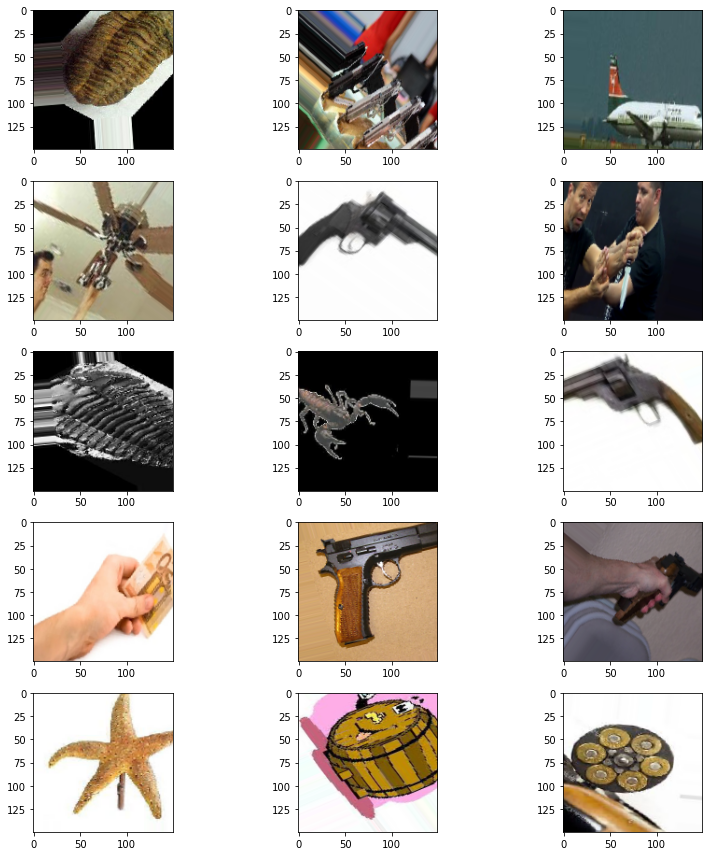

In [40]:
sample_print(train)

In [41]:
valid = loader("validation", augmentation=False, batch_size=100)
test_set = loader("test", augmentation=False, batch_size=100)

Found 3108 images belonging to 2 classes.
Found 3108 images belonging to 2 classes.


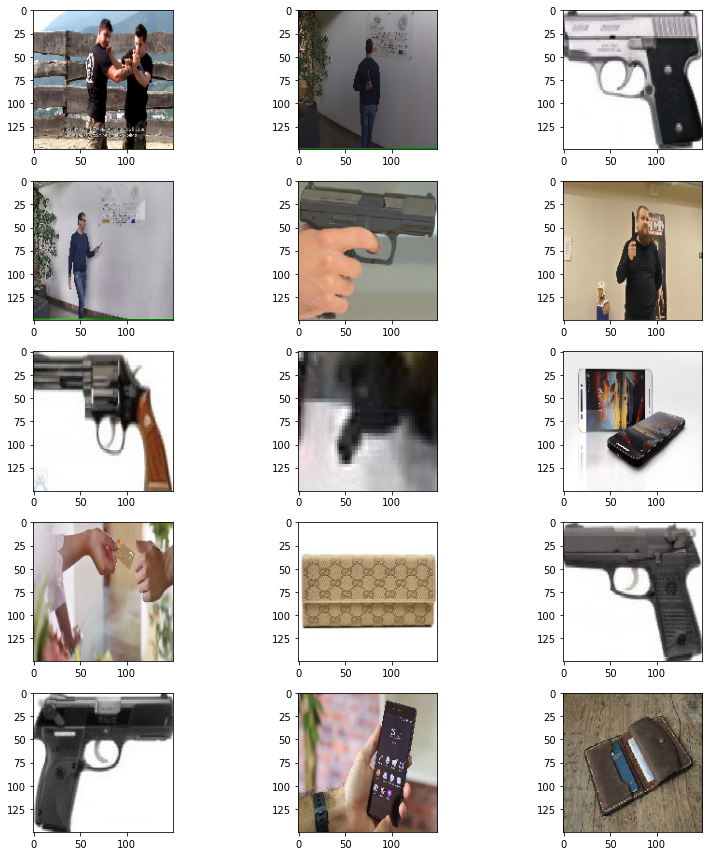

In [42]:
sample_print(valid)

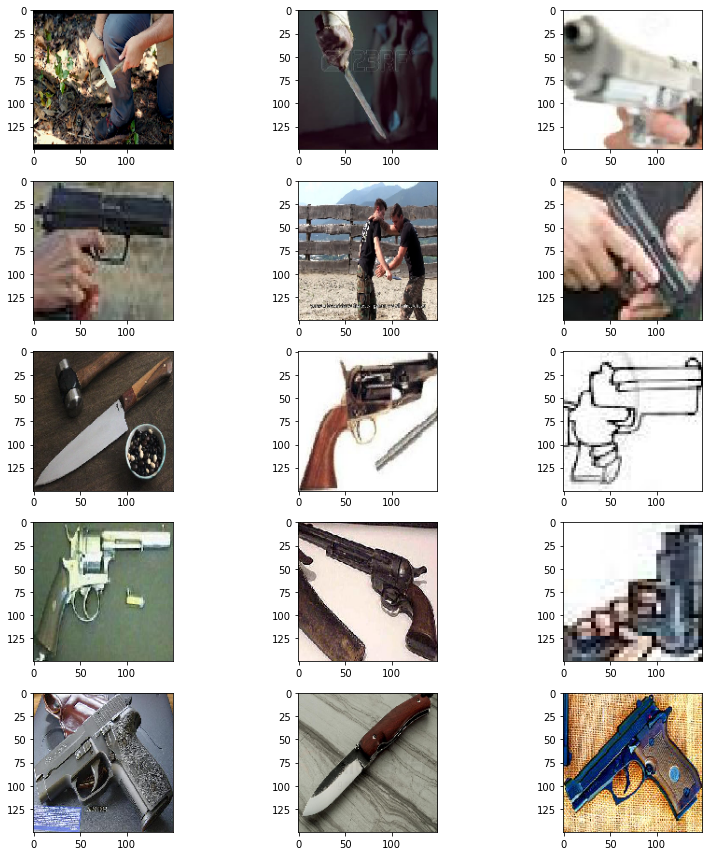

In [43]:
sample_print(test_set)

# MODEL CREATION

In [26]:
# Initialising the CNN
classifier = Sequential()

# Step 1 - Convolution
classifier.add(Conv2D(32, (3, 3), activation = 'relu',  input_shape = (150,150,3)))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier.add(Conv2D(64, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a third convolutional layer
classifier.add(Conv2D(128, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))


# Step 3 - Flattening
classifier.add(Flatten())

# Step 3.5 - Dropout
classifier.add(Dropout(.3))

# Step 4 - Full connection
classifier.add(Dense(units = 256, activation = 'relu'))
classifier.add(Dense(units = 1, activation = 'sigmoid'))

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [27]:
history = classifier.fit(
    train,
    steps_per_epoch=9324 //100,
    epochs = 10,
    validation_data = valid,
    validation_steps = 3108//100 
)

Epoch 1/10
93/93 [==============================] - 159s 2s/step - loss: 0.6711 - accuracy: 0.6236 - val_loss: 0.5029 - val_accuracy: 0.7403
Epoch 2/10
93/93 [==============================] - 158s 2s/step - loss: 0.5430 - accuracy: 0.7239 - val_loss: 0.4281 - val_accuracy: 0.8229
Epoch 3/10
93/93 [==============================] - 160s 2s/step - loss: 0.5207 - accuracy: 0.7335 - val_loss: 0.4153 - val_accuracy: 0.8206
Epoch 4/10
93/93 [==============================] - 158s 2s/step - loss: 0.4877 - accuracy: 0.7600 - val_loss: 0.4870 - val_accuracy: 0.7442
Epoch 5/10
93/93 [==============================] - 159s 2s/step - loss: 0.4715 - accuracy: 0.7676 - val_loss: 0.4070 - val_accuracy: 0.8268
Epoch 6/10
93/93 [==============================] - 159s 2s/step - loss: 0.4573 - accuracy: 0.7820 - val_loss: 0.4264 - val_accuracy: 0.8097
Epoch 7/10
93/93 [==============================] - 158s 2s/step - loss: 0.4467 - accuracy: 0.7842 - val_loss: 0.3978 - val_accuracy: 0.8200
Epoch 8/10
93

In [37]:
# PREDICT & CLASSIFICATION REPORT


#test_set = loader("test", augmentation=False, batch_size=100)

# if you have the last version of tensorflow, the predict_generator is deprecated.
# you should use the predict method.
# if you do not have the last version, you must use predict_generator
Y_pred = (classifier.predict(test_set) > 0.5).astype("int32") # ceil(num_of_test_samples / batch_size)
#Y_pred = (Y_pred<0.5)
print('Confusion Matrix')
print(confusion_matrix(test_set.classes, Y_pred))
print('Classification Report')
#target_names = ['Cats', 'Dogs']
print(classification_report(test_set.classes, Y_pred))

Confusion Matrix
[[660 894]
 [629 925]]
Classification Report
              precision    recall  f1-score   support

           0       0.51      0.42      0.46      1554
           1       0.51      0.60      0.55      1554

    accuracy                           0.51      3108
   macro avg       0.51      0.51      0.51      3108
weighted avg       0.51      0.51      0.51      3108



## TRIAL #2 -  REMOVE DROPOUT 

In [10]:
# Initialising the CNN
classifier2 = Sequential()

# Step 1 - Convolution
classifier2.add(Conv2D(32, (3, 3), activation = 'relu',  input_shape = (150,150,3)))
classifier2.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier2.add(Conv2D(64, (3, 3), activation = 'relu'))
classifier2.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a third convolutional layer
classifier2.add(Conv2D(128, (3, 3), activation = 'relu'))
classifier2.add(MaxPooling2D(pool_size = (2, 2)))


# Step 3 - Flattening
classifier2.add(Flatten())

# Step 3.5 - Dropout
#classifier.add(Dropout(.3))

# Step 4 - Full connection
classifier2.add(Dense(units = 256, activation = 'relu'))
classifier2.add(Dense(units = 1, activation = 'sigmoid'))

# Compiling the CNN
classifier2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [11]:
history2 = classifier2.fit(
    train,
    steps_per_epoch=9324 //100,
    epochs = 10,
    validation_data = valid,
    validation_steps = 3108//100 
)

Epoch 1/10
93/93 [==============================] - 171s 2s/step - loss: 0.6414 - accuracy: 0.6486 - val_loss: 0.4994 - val_accuracy: 0.7787
Epoch 2/10
93/93 [==============================] - 161s 2s/step - loss: 0.5151 - accuracy: 0.7376 - val_loss: 0.5170 - val_accuracy: 0.7294
Epoch 3/10
93/93 [==============================] - 162s 2s/step - loss: 0.4834 - accuracy: 0.7638 - val_loss: 0.4606 - val_accuracy: 0.7839
Epoch 4/10
93/93 [==============================] - 163s 2s/step - loss: 0.4505 - accuracy: 0.7809 - val_loss: 0.5072 - val_accuracy: 0.7423
Epoch 5/10
93/93 [==============================] - 157s 2s/step - loss: 0.4337 - accuracy: 0.7936 - val_loss: 0.4468 - val_accuracy: 0.7765
Epoch 6/10
93/93 [==============================] - 156s 2s/step - loss: 0.4301 - accuracy: 0.7992 - val_loss: 0.4433 - val_accuracy: 0.7848
Epoch 7/10
93/93 [==============================] - 155s 2s/step - loss: 0.3992 - accuracy: 0.8134 - val_loss: 0.4854 - val_accuracy: 0.7471
Epoch 8/10
93

In [18]:
# PREDICT & CLASSIFICATION REPORT
Y_pred = (classifier2.predict(test_set, batch_size=3108//100) > 0.5).astype("int32")

print('Confusion Matrix')
print(confusion_matrix(test_set.classes, Y_pred))

print('Classification Report')
target_names = ['Pistols', 'Others']
print(classification_report(test_set.classes, Y_pred, target_names=target_names))

Confusion Matrix
[[ 384 1170]
 [ 345 1209]]
Classification Report
              precision    recall  f1-score   support

     Pistols       0.53      0.25      0.34      1554
      Others       0.51      0.78      0.61      1554

    accuracy                           0.51      3108
   macro avg       0.52      0.51      0.48      3108
weighted avg       0.52      0.51      0.48      3108



It seem that using Dropout actually improves model performance!

## TRIAL #3 - ADD DROPOUT - INCREASE # OF NEURONS (x2) IN THE CONV LAYERS - 5 EPOCHS!

In [44]:
# Initialising the CNN
classifier3 = Sequential()

# Step 1 - Convolution
classifier3.add(Conv2D(64, (3, 3), activation = 'relu',  input_shape = (150,150,3)))
classifier3.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier3.add(Conv2D(128, (3, 3), activation = 'relu'))
classifier3.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a third convolutional layer
classifier3.add(Conv2D(256, (3, 3), activation = 'relu'))
classifier3.add(MaxPooling2D(pool_size = (2, 2)))


# Step 3 - Flattening
classifier3.add(Flatten())

# Step 3.5 - Dropout
classifier3.add(Dropout(.3))

# Step 4 - Full connection
classifier3.add(Dense(units = 256, activation = 'relu'))
classifier3.add(Dense(units = 1, activation = 'sigmoid'))

# Compiling the CNN
classifier3.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [45]:
history3 = classifier3.fit(
    train,
    steps_per_epoch=9324 //100,
    epochs = 5,
    validation_data = valid,
    validation_steps = 3108//100 
)

Epoch 1/5
93/93 [==============================] - 263s 3s/step - loss: 0.7178 - accuracy: 0.6074 - val_loss: 0.5304 - val_accuracy: 0.7781
Epoch 2/5
93/93 [==============================] - 261s 3s/step - loss: 0.5427 - accuracy: 0.7242 - val_loss: 0.4495 - val_accuracy: 0.7984
Epoch 3/5
93/93 [==============================] - 256s 3s/step - loss: 0.5171 - accuracy: 0.7414 - val_loss: 0.4774 - val_accuracy: 0.7826
Epoch 4/5
93/93 [==============================] - 248s 3s/step - loss: 0.4927 - accuracy: 0.7567 - val_loss: 0.4145 - val_accuracy: 0.8142
Epoch 5/5
93/93 [==============================] - 252s 3s/step - loss: 0.4767 - accuracy: 0.7690 - val_loss: 0.4465 - val_accuracy: 0.8065


In [48]:
# evaluate model
_, acc = classifier3.evaluate(test_set, steps=len(test_set))
print('> %.3f' % (acc * 100.0))

32/32 [==============================] - 25s 768ms/step - loss: 0.6335 - accuracy: 0.6885
> 68.855


In [52]:
# PREDICT & CLASSIFICATION REPORT
Y_pred = (classifier2.predict(test_set) > 0.5).astype("int32")

print('Confusion Matrix')
print(confusion_matrix(test_set.classes, Y_pred))

print('Classification Report')
target_names = ['Pistols', 'Others']
print(classification_report(test_set.classes, Y_pred, target_names=target_names))

Confusion Matrix
[[ 627  927]
 [ 538 1016]]
Classification Report
              precision    recall  f1-score   support

     Pistols       0.54      0.40      0.46      1554
      Others       0.52      0.65      0.58      1554

    accuracy                           0.53      3108
   macro avg       0.53      0.53      0.52      3108
weighted avg       0.53      0.53      0.52      3108



Increasing the neuron # caused overfitting!

## TRIAL #4 - INCREASE # OF HIDDEN LAYERS (3 -> 4) (BACK TO ORIGINAL NEURON #) - 5 EPOCHS!

In [22]:
# Initialising the CNN
classifier4 = Sequential()

# Step 1 - Convolution
classifier4.add(Conv2D(32, (3, 3), activation = 'relu',  input_shape = (150,150,3)))
classifier4.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier4.add(Conv2D(64, (3, 3), activation = 'relu'))
classifier4.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a third convolutional layer
classifier4.add(Conv2D(128, (3, 3), activation = 'relu'))
classifier4.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a fourth convolutional layer
classifier4.add(Conv2D(128, (3, 3), activation = 'relu'))
classifier4.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
classifier4.add(Flatten())

# Step 3.5 - Dropout
classifier4.add(Dropout(.3))

# Step 4 - Full connection
classifier4.add(Dense(units = 256, activation = 'relu'))
classifier4.add(Dense(units = 1, activation = 'sigmoid'))

# Compiling the CNN
classifier4.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
history4 = classifier4.fit(
    train,
    steps_per_epoch=9324 //100,
    epochs = 5,
    validation_data = valid,
    validation_steps = 3108//100 
)

## TRIAL #5 - DECREASE # OF NEURONS (256 -> 128) IN THE DENSE LAYER  - 5 EPOCHS!

In [ ]:
# Initialising the CNN
classifier5 = Sequential()

# Step 1 - Convolution
classifier5.add(Conv2D(32, (3, 3), activation = 'relu',  input_shape = (150,150,3)))
classifier5.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier5.add(Conv2D(64, (3, 3), activation = 'relu'))
classifier5.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a third convolutional layer
classifier5.add(Conv2D(128, (3, 3), activation = 'relu'))
classifier5.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a fourth convolutional layer
classifier5.add(Conv2D(128, (3, 3), activation = 'relu'))
classifier5.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
classifier5.add(Flatten())

# Step 3.5 - Dropout
classifier5.add(Dropout(.3))

# Step 4 - Full connection
classifier5.add(Dense(units = 128, activation = 'relu'))
classifier5.add(Dense(units = 1, activation = 'sigmoid'))

# Compiling the CNN
classifier5.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
history5 = classifier5.fit(
    train,
    steps_per_epoch=9324 //100,
    epochs = 5,
    validation_data = valid,
    validation_steps = 3108//100 
)

## TRIAL #6 - INTERNET

In [55]:
from keras.optimizers import SGD
# define cnn model
def define_model6():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(150, 150, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

In [56]:
classifier6 = define_model6()

In [57]:
history6 = classifier6.fit(
    train,
    steps_per_epoch=9324 //100,
    epochs = 5,
    validation_data = valid,
    validation_steps = 3108//100 
)

Epoch 1/5
93/93 [==============================] - 161s 2s/step - loss: 0.6577 - accuracy: 0.6013 - val_loss: 0.5270 - val_accuracy: 0.7758
Epoch 2/5
93/93 [==============================] - 160s 2s/step - loss: 0.6052 - accuracy: 0.6580 - val_loss: 0.5580 - val_accuracy: 0.7332
Epoch 3/5
93/93 [==============================] - 162s 2s/step - loss: 0.5806 - accuracy: 0.6848 - val_loss: 0.4980 - val_accuracy: 0.7816
Epoch 4/5
93/93 [==============================] - 160s 2s/step - loss: 0.5399 - accuracy: 0.7241 - val_loss: 0.5351 - val_accuracy: 0.7255
Epoch 5/5
93/93 [==============================] - 159s 2s/step - loss: 0.5214 - accuracy: 0.7356 - val_loss: 0.5193 - val_accuracy: 0.7500


Found 9324 images belonging to 2 classes.
Found 3108 images belonging to 2 classes.
> 67.632


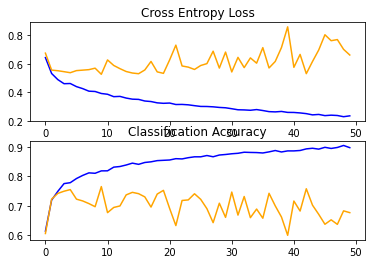

In [58]:
# baseline model with data augmentation for the dogs vs cats dataset
import sys
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	#filename = sys.argv[0].split('/')[-1]
	#pyplot.savefig(filename + '_plot.png')
	#pyplot.close()

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model = define_model()
	# create data generators
	train_datagen = ImageDataGenerator(rescale=1.0/255.0,
		width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
	test_datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = train_datagen.flow_from_directory('data/cooked/train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = test_datagen.flow_from_directory('data/cooked/test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	# fit model
	history = model.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=0)
	# evaluate model
	_, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()

In [60]:
valid_datagen = ImageDataGenerator(rescale=1.0/255.0)

valid_it = valid_datagen.flow_from_directory('data/cooked/validation/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
model.predict(valid_it,steps=len(valid_it))

Found 3108 images belonging to 2 classes.


NameError: name 'model' is not defined

# TRIALS FOR GRIDSEARCH MODEL FUNCTION

In [45]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [44]:
def create_model():
    # Initialising the CNN
    classifier = Sequential()
    # Step 1 - Convolution
    classifier.add(Conv2D(64, (3, 3), activation = 'relu',  input_shape = (150,150,3)))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    # Adding a second convolutional layer
    classifier.add(Conv2D(128, (3, 3), activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    # Adding a third convolutional layer
    classifier.add(Conv2D(128, (3, 3), activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    # Adding a fourth convolutional layer
    classifier.add(Conv2D(128, (3, 3), activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size = (2, 2)))
    # Step 3 - Flattening
    classifier.add(Flatten())
    # Step 3.5 - Dropout
    classifier.add(Dropout(dropout_rate))
    # Step 4 - Full connection
    classifier.add(Dense(units = 256, activation = 'relu'))
    classifier.add(Dense(units = 1, activation = 'sigmoid'))
    # Compiling the CNN
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier
 

X, Y = train.next()

model = KerasClassifier(build_fn=create_model, verbose=0, epochs=5)

batch_size = [10, 20, 40, 60, 80, 100]
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
learn_rate = [0.001, 0.01, 0.1, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8]
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
weight_constraint = [1, 2, 3, 4, 5]
dropout_rate = [0.0, 0.3, 0.5]
neurons1 = [16, 32, 64]
neurons2 = [64, 128, 256]
neurons3 = [64, 128, 256]
neuronsdense = [32,64,128,256]



param_grid = dict(batch_size=batch_size, )
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)
grid_result = grid.fit(X, Y)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

NameError: name 'KerasClassifier' is not defined